In [1]:
%run 2-source.ipynb
#low_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'Low'"]
#high_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'High'"]

# Functional connectivity

In [ ]:
from pathlib import Path

from mne import (make_forward_solution, setup_source_space,
                 setup_volume_source_space)
from mne.io import read_raw_fif
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

In [ ]:
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package) # for all regions use 'all'
for l in rel_labels:
    l.name = f"{rel_mappings[l.name]}-{l.hemi}"

Reading labels from parcellation...
   read 82 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot


In [ ]:
def get_connectivity_plot(rel_stcs, output_dir, fmin, fmax, fig_title = 'Motor'):
    # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
    labels_parc = mne.read_labels_from_annot(subject, parc='aparc',
                                            subjects_dir=subjects_dir)
    labels_parc = rel_labels
    # Average the source estimates within each label of the cortical parcellation
    # and each sub-structure contained in the source space.
    # When mode = 'mean_flip', this option is used only for the cortical labels.
    src = inverse_operator['src']
    label_ts = mne.extract_label_time_course(
        rel_stcs, labels_parc, src, mode='mean_flip', allow_empty=True,
        return_generator=True, verbose=False)

    # We compute the connectivity in the alpha band and plot it using a circular
    # graph layout
    fmin = fmin
    fmax = fmax
    sfreq = motor_epochs.info['sfreq']  # the sampling frequency
    con = spectral_connectivity_epochs(
        label_ts, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin,
        fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=5,verbose=False)

    # We create a list of Label containing also the sub structures
    labels_aseg = mne.get_volume_labels_from_src(src, subject, subjects_dir)
    labels = labels_parc + labels_aseg

    # read colors
    node_colors = [label.color for label in labels]

    # We reorder the labels based on their location in the left hemi
    label_names = [label.name for label in labels]
    lh_labels = [name for name in label_names if name.endswith('lh')]
    rh_labels = [name for name in label_names if name.endswith('rh')]

    # Get the y-location of the label
    label_ypos_lh = list()
    for name in lh_labels:
        idx = label_names.index(name)
        ypos = np.mean(labels[idx].pos[:, 1])
        label_ypos_lh.append(ypos)
    try:
        idx = label_names.index('Brain-Stem')
    except ValueError:
        pass
    else:
        ypos = np.mean(labels[idx].pos[:, 1])
        lh_labels.append('Brain-Stem')
        label_ypos_lh.append(ypos)


    # Reorder the labels based on their location
    lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

    # For the right hemi
    rh_labels = [label[:-2] + 'rh' for label in lh_labels
                if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]

    # Save the plot order
    node_order = lh_labels[::-1] + rh_labels

    node_angles = circular_layout(label_names, node_order, start_pos=90,
                                group_boundaries=[0, len(label_names) // 2])


    # Plot the graph using node colors from the FreeSurfer parcellation. We only
    # show the 300 strongest connections.
    conmat = con.get_data(output='dense')[:, :, 0]

    fig, ax = plt.subplots(figsize=(8, 8), facecolor='black',
                        subplot_kw=dict(polar=True))
    plot_connectivity_circle(conmat, label_names, n_lines=300, vmin = 0, vmax = .30,
                            node_angles=node_angles, node_colors=node_colors,
                            title=f"All-to-All Connectivity {fig_title} Epochs", ax=ax)
    fig.tight_layout()
    Path(f"{output_dir}/connectivity").mkdir(parents=True, exist_ok=True)
    fname_fig = f"{output_dir}/connectivity/{fig_title}_plot_mixed_connect.png"
    fig.savefig(fname_fig, facecolor=fig.get_facecolor())
    np.save(f"{output_dir}/connectivity/{fig_title}_conn",conmat)

## NOTE WE LIMIT TO 2000 EPOCHS FOR MEMORY USAGE


band (4.0, 8.0, 'Theta')
Reading labels from parcellation...
   read 35 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (mode: m

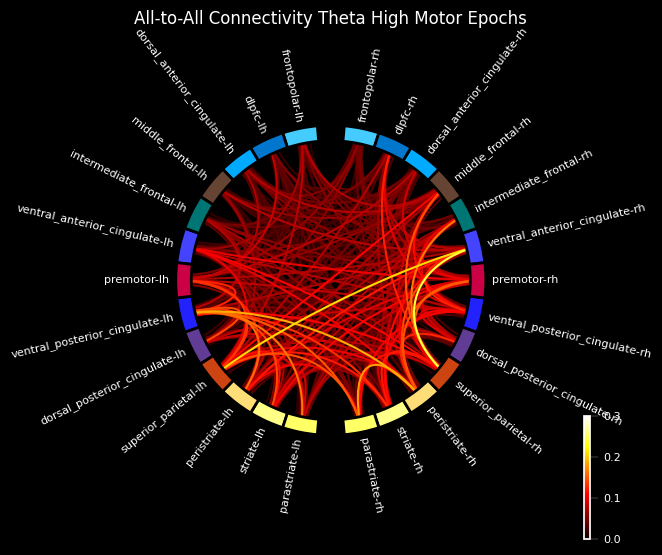

band (8.0, 15.0, 'Alpha')
Reading labels from parcellation...
   read 35 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 8.7Hz..14.3Hz (8 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (mode:

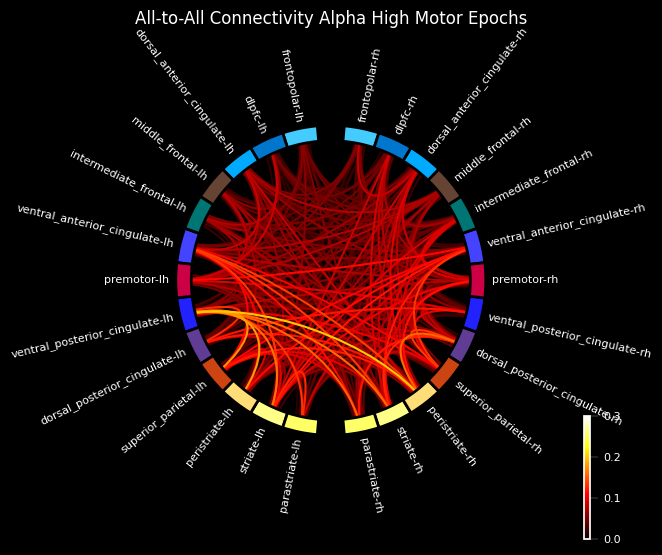

band (15.0, 32.0, 'Beta')
Reading labels from parcellation...
   read 35 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 15.1Hz..31.8Hz (22 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (mod

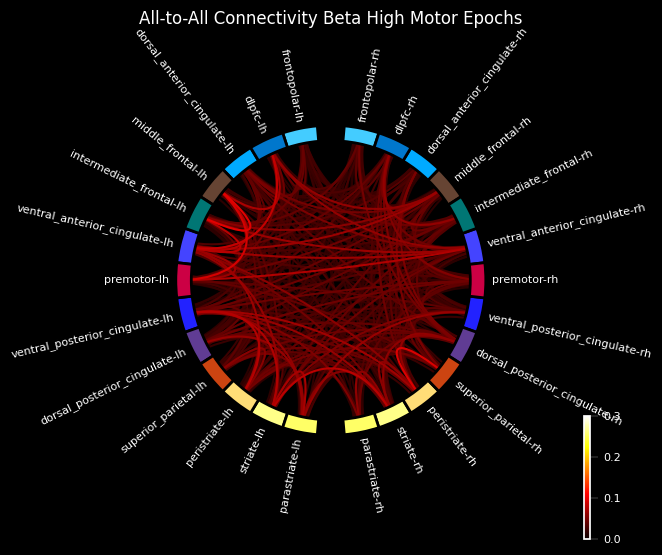

band (32.0, 55.0, 'Gamma')
Reading labels from parcellation...
   read 35 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 32.6Hz..54.9Hz (29 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (mo

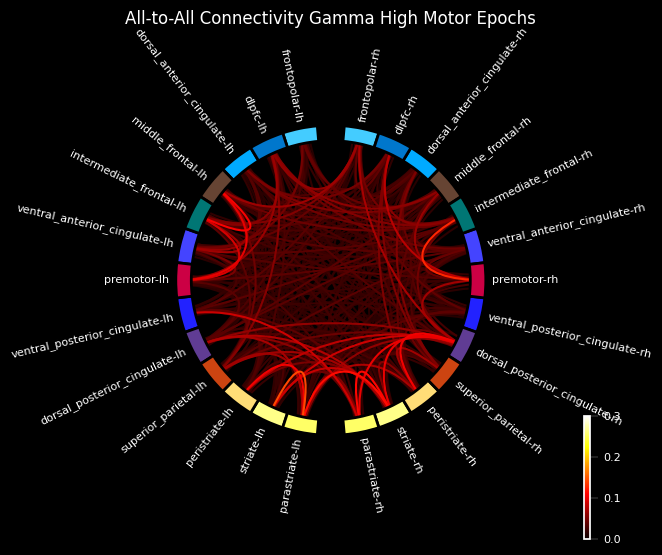

In [ ]:
bands = [(4.,8.,'Theta'), (8.,15.,'Alpha'), (15.,32.,'Beta'), (32., 55., 'Gamma')]

if False:
    cond = 'Low'
    rel_stcs = mne.minimum_norm.apply_inverse_epochs(low_motor_sensor, inverse_operator,
                                    lambda2=1.0 / snr ** 2, verbose=False,
                                    method="eLORETA", pick_ori="normal")
    for band in bands:
        print('band', band)
        get_connectivity_plot(rel_stcs,output_dir,fmin = band[0], fmax = band[1], fig_title = f"{band[2]} {cond} Motor")


    cond = 'High'
    rel_stcs = mne.minimum_norm.apply_inverse_epochs(high_motor_sensor, inverse_operator,
                                    lambda2=1.0 / snr ** 2, verbose=False,
                                    method="eLORETA", pick_ori="normal")
    for band in bands:
        print('band', band)
        get_connectivity_plot(rel_stcs,output_dir,fmin = band[0], fmax = band[1], fig_title = f"{band[2]} {cond} Motor")

cond = 'All'
rel_stcs = mne.minimum_norm.apply_inverse_epochs(motor_epochs, inverse_operator,
                                lambda2=1.0 / snr ** 2, verbose=False,
                                method="eLORETA", pick_ori="normal")
for band in bands:
    print('band', band)
    get_connectivity_plot(rel_stcs,output_dir,fmin = band[0], fmax = band[1], fig_title = f"{band[2]} {cond} Motor")

# Decoding source space data

In [ ]:
from mne.decoding import (LinearModel, SlidingEstimator, cross_val_multiscore,
                          get_coef)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
interval = 4
stcs = mne.minimum_norm.apply_inverse_epochs(motor_epochs[::interval], inverse_operator,
                            lambda2=1.0 / snr ** 2, verbose=False,
                            method="eLORETA", pick_ori="normal")

In [ ]:
# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = motor_epochs[::interval].metadata.Steer_Wheel_Degree_Encoded # for sparse: motor_epochs[::7]

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='lbfgs')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [ ]:
# The fitting needs not be cross validated because the weights are based on
# the training sets
time_decod.fit(X, y)

# Retrieve patterns after inversing the z-score normalization step:
patterns = get_coef(time_decod, 'patterns_', inverse_transform=True)

stc = stcs[0]  # for convenience, lookup parameters from first stc
vertices = [stc.lh_vertno, np.array([], int)]  # empty array for right hemi
stc_feat = mne.SourceEstimate(np.abs(patterns), vertices=vertices,
                              tmin=stc.tmin, tstep=stc.tstep, subject='fsaverage')

brain = stc_feat.plot(views=['lat'], transparent=True, subject='fsaverage',time_unit='s')

### CSP

In [ ]:
# Retrieve source space data into an array
print('starting')
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = np.array(motor_epochs[::interval].metadata.Steer_Wheel_Degree_Encoded)
print('decoding')
csp = mne.decoding.CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(
    csp
)
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

In [ ]:
X.shape, y.shape

In [ ]:

# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])
y = motor_epochs[::7].metadata.Abs_Steer_Wheel_Degree

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LinearRegression()))
time_decod = SlidingEstimator(clf, scoring='neg_mean_squared_error')
# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, -scores.mean(0), label='score')
ax.axhline(mean_squared_error(y,[np.mean(y)]*len(y)), color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [ ]:
y = motor_epochs.metadata.Abs_Steer_Wheel_Degree

print(mean_squared_error(y,[np.mean(y)]*len(y),squared=False)), print(np.sqrt(0.025))

## Source permutation t-tests with clustering

In [ ]:
#low_motor.resample(50, npad='auto')
condition1 = mne.minimum_norm.apply_inverse(low_motor_sensor.average(), inverse_operator, lambda2, method)
#high_motor.resample(50, npad='auto')
condition2 = mne.minimum_norm.apply_inverse(high_motor_sensor.average(), inverse_operator, lambda2, method)

tmin = condition1.tmin
tstep = condition1.tstep * 1000  # convert to milliseconds

In [ ]:
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
import scipy
src = mne.read_source_spaces(src_fname)
n_subjects1, n_subjects2 = 60, 60
n_vertices_fsave, n_times = condition1.data.shape
print('Simulating data for %d and %d subjects.' % (n_subjects1, n_subjects2))

#    Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X1 = np.random.randn(n_vertices_fsave, n_times, n_subjects1)*10
X2 = np.random.randn(n_vertices_fsave, n_times, n_subjects2)*10
X1[:, :, :] += condition1.data[:, :, np.newaxis]
X2[:, :, :] += 3*condition2.data[:, :, np.newaxis]
#    We want to compare the overall activity levels for each subject
X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude
print('Computing adjacency.')
adjacency = spatial_src_adjacency(src)

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions
X1 = np.transpose(X1, [2, 1, 0])
X2 = np.transpose(X2, [2, 1, 0])
X = [X1, X2]
# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.
n_permutations = 50 # 50 to test, 1024 ideally
p_threshold = .05
f_threshold = scipy.stats.distributions.f.ppf(1. - p_threshold / 2.,
                                        n_subjects1 - 1, n_subjects2 - 1)
print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu =\
    spatio_temporal_cluster_test(
        X, adjacency=adjacency, n_jobs=5, n_permutations=n_permutations,
        threshold=f_threshold, buffer_size=None)
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05 )[0]

In [ ]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,p_thresh=.05, tmin=-1,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot('fsaverage', hemi='both',
                                 views='lateral', subjects_dir=subjects_dir,
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))